# Challenge: Iterate and evaluate Classifier

Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

1. Do any of your classifiers seem to overfit?
2. Which seem to perform the best? Why?
3. Which features seemed to be most impactful to performance?


Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

In [1]:
######### Imports ###########
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#For selecting features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [2]:
####### Import Data #########
data = pd.read_csv('yelp_labelled.txt', delimiter= '\t', header=None)
data.columns = ['message', 'Positive?']
data.head()

,message,Positive?
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
message      1000 non-null object
Positive?    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


### Feature Engineering

Since this is yelp data, its important to understand the context in which something is good or bad. In the case of yelp, its reviews on restaurants, so there will be particular words associated with being positive.

In [3]:
######### Confusion Matrix ###############

#Create Check function
def check(cols):
    return cols[0]==cols[1]

def custom_confusion_matrix(target, prediction):
    #Need to combine the 2 series into a single data frame
    s1 = pd.Series(target, name='target')
    s2 = pd.Series(y_pred, name='prediction')
    output = pd.concat([s1,s2], axis=1)
    
    #Add Check 
    output['check'] = output[['target','prediction']].apply(check, axis=1)
    
    #Predicted False Correctly
    fc = output[((output['target']==0) & (output['check']==True))].count()['target']
    
    #Predicted False Incorrectly
    fi = output[((output['target']==0) & (output['check']==False))].count()['target']
    
    #Predicted True Correctly
    tc = output[((output['target']==1) & (output['check']==True))].count()['target']
    
    #Predicted True Incorrectly
    ti = output[((output['target']==1) & (output['check']==False))].count()['target']
    
    print('Predicted False Correctly {} times and incorrectly {} out of {}'.format
          (fc,fi, int(fc+fi)))
    print('Specificity is {}%'.format(fc*100/(fc+fi)))
    
    print('Predicted True Correctly {} times and incorrectly {} out of {}'.format
          (tc,ti, int(tc+ti)))
    print('Sensitivty is {}%'.format(tc*100/(tc+ti)))

Positive

In [4]:
###### Determine words most associated with Positive ######

#Goal: Want to create a list of words with counts

#First need to collect all the positive messages
positive = data[data['Positive?']==1]

full_list = []

#Create super list of all words
for sentence in data[data['Positive?']==1]['message'].tolist():
    words = sentence.split(' ')
    full_list.extend(words)
    
counts = Counter(full_list)

#Turn into Dataframe
positive_word_count = pd.DataFrame.from_dict(counts, orient='index')
positive_word_count.columns=['Count']

#Add length of word
positive_word_count['Length of word'] = positive_word_count.index.map(lambda x: len(x))

positive_word_count.sort_values(by=['Count'], inplace=True, ascending=False)
positive_word_count.head()

,Count,Length of word
and,218,3
the,214,3
was,137,3
I,113,1
a,107,1


Negative

In [5]:
###### Determine words most associated with Negative ######

#Goal: Want to create a list of words with counts

#First need to collect all the positive messages
positive = data[data['Positive?']==0]

full_list = []

#Create list of all words
for sentence in data[data['Positive?']==0]['message'].tolist():
    words = sentence.split(' ')
    full_list.extend(words)
    
counts = Counter(full_list)

#Turn into Dataframe
negative_word_count = pd.DataFrame.from_dict(counts, orient='index')
negative_word_count.columns=['Count']

#Add length of word
negative_word_count['Length of word'] = negative_word_count.index.map(lambda x: len(x))

negative_word_count.sort_values(by=['Count'], inplace=True, ascending=False)
negative_word_count.head()

,Count,Length of word
the,191,3
I,181,1
and,160,3
was,155,3
to,129,2


In [6]:
#Want to add Positivity and Negativty measures
#IS a particular word more associated with positive reviews vs negative reviews
def get_count(dataframe, index):
    try:
        return dataframe.loc[index]['Count']
    except:
        return 0

def calc_positivity(word):
    positive = get_count(positive_word_count, word)
    negative = get_count(negative_word_count, word)
    denominator = positive+negative
    
    if denominator == 0:
        return 0
    else:
        return (positive/(positive+negative))*100

def calc_negativity(word):
    positive = get_count(positive_word_count, word)
    negative = get_count(negative_word_count, word)
    denominator = positive+negative
    
    if denominator == 0:
        return 0
    else:
        return (negative/(positive+negative))*100

In [7]:
#Add measure to dataframes
positive_word_count['Positivity Percent'] = positive_word_count.index.map(lambda x: calc_positivity(x))
negative_word_count['Negativity Percent'] = negative_word_count.index.map(lambda x: calc_negativity(x))

In [8]:
######### Positive ###############
#Now can look at words over a certain length
positive_word_count[positive_word_count['Length of word']>=4].head(20).transpose()

,this,good,with,very,place,great,food,were,have,This,really,time,Great,service,they,here,that,friendly,like,just
Count,47.000000,42.0,41.000000,39.0,39.000000,37.0,37.00,34.000000,31.000000,29.000000,21.000000,19.000000,19.0,19.000000,19.0,18.0,18.000000,16.000000,16.000000,15.0
Length of word,4.000000,4.0,4.000000,4.0,5.000000,5.0,4.00,4.000000,4.000000,4.000000,6.000000,4.000000,5.0,7.000000,4.0,4.0,4.000000,8.000000,4.000000,4.0
Positivity Percent,49.473684,75.0,57.746479,65.0,51.315789,100.0,46.25,55.737705,52.542373,63.043478,67.741935,54.285714,100.0,46.341463,50.0,50.0,30.508475,88.888889,35.555556,50.0


In [9]:
######### Negative #############
#Now can look at words over a certain length
negative_word_count[negative_word_count['Length of word']>=5].head(20).transpose()

,place,service,don't,would,there,never,minutes,won't,wasn't,being,back.,think,going,food.,again.,their,really,which,about,because
Count,37.000000,22.000000,19.000000,19.0,15.000000,15.000000,14.0,13.000000,13.0,13.000000,13.000000,13.00,13.000000,11.000000,11.000000,11.000000,10.000000,10.000000,10.000000,10.000000
Length of word,5.000000,7.000000,5.000000,5.0,5.000000,5.000000,7.0,5.000000,6.0,5.000000,5.000000,5.00,5.000000,5.000000,6.000000,5.000000,6.000000,5.000000,5.000000,7.000000
Negativity Percent,48.684211,53.658537,86.363636,76.0,71.428571,83.333333,100.0,76.470588,100.0,92.857143,72.222222,81.25,72.222222,61.111111,73.333333,47.826087,32.258065,52.631579,58.823529,71.428571


### Version 1

This is from the original excercise.

In [10]:
####### Add Keywords #######
keywords = ['good', 'great', 'Great', 'friendly', 'love',
            'nice', 'loved', 'delicious!', 'amazing', 'excellent','fresh', 'never', 'being', 'minutes', 'wasn\'t']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    data[str(key)] = data.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [11]:
data.head()

,message,Positive?,good,great,Great,friendly,love,nice,loved,delicious!,amazing,excellent,fresh,never,being,minutes,wasn't
0,Wow... Loved this place.,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Crust is not good.,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty.,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,The selection on the menu was great and so wer...,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False


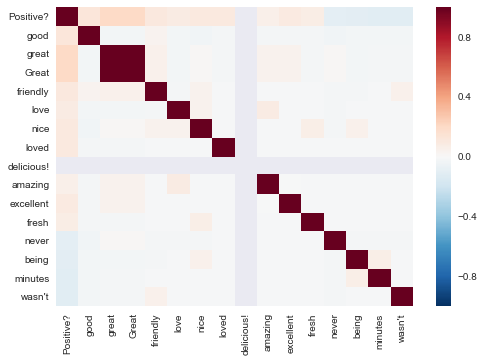

In [12]:
#Look at Correlation
sns.heatmap(data.corr())

Create Model

In [11]:
#Create training data
training_data = data[keywords]
target = data['Positive?']

In [12]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(training_data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(training_data)

# Display our results.
print("Accuracy Score is : {}%".format(
    ((target == y_pred).sum()/training_data.shape[0])*100
))

Accuracy Score is : 62.0%


In [13]:
custom_confusion_matrix(target, y_pred)

Predicted False Correctly 478 times and incorrectly 22 out of 500
Specificity is 95.6%
Predicted True Correctly 142 times and incorrectly 358 out of 500
Sensitivty is 28.4%


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[478,  22],
       [358, 142]])

### Version 2

Use Select K best to determing the top 5 features and then just use those.

In [15]:
selector = SelectKBest(f_classif, k=5)
selector.fit(training_data,target)

idxs_selected = selector.get_support(indices=True)
training_data[training_data.columns[idxs_selected]].head()

/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [7] are constant.
  UserWarning)
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,good,great,Great,minutes,wasn't
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,True,True,False,False


In [16]:
####### Add Keywords #######
keywords = ['good', 'great', 'Great', 'minutes', 'wasn\'t']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    data[str(key)] = data.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
###### Create Model ########
#Create training data
training_data = data[keywords]
target = data['Positive?']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(training_data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(training_data)

# Display our results.
print("Accuracy Score is : {}%".format(
    ((target == y_pred).sum()/training_data.shape[0])*100
))

custom_confusion_matrix(target, y_pred)

Accuracy Score is : 56.49999999999999%
Predicted False Correctly 486 times and incorrectly 14 out of 500
Specificity is 97.2%
Predicted True Correctly 79 times and incorrectly 421 out of 500
Sensitivty is 15.8%


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[486,  14],
       [421,  79]])

### Version 3

Want to look at the positivity and negativity at a higher percentage then do k 10 best.

In [18]:
######### Positive ###############
#Now can look at words over a certain length
positive_word_count[positive_word_count['Positivity Percent']>=80].head(20).transpose()

,great,Great,friendly,nice,love,first,best,happy,menu,fresh,excellent,Vegas,every,Best,delicious!,amazing,steak,delicious.,5,Their
Count,37.0,19.0,16.000000,14.0,13.00,12.0,11.000000,8.0,8.000000,8.000000,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
Length of word,5.0,5.0,8.000000,4.0,4.00,5.0,4.000000,5.0,4.000000,5.000000,9.0,5.0,5.0,4.0,10.0,7.0,5.0,10.0,1.0,5.0
Positivity Percent,100.0,100.0,88.888889,87.5,81.25,80.0,91.666667,100.0,88.888889,88.888889,100.0,80.0,87.5,87.5,100.0,87.5,87.5,100.0,87.5,87.5


In [24]:
######### Negative #############
#Now can look at words over a certain length
negative_word_count[negative_word_count['Negativity Percent']>=80].head(20).transpose()

,not,don't,no,much,got,never,minutes,wasn't,being,think,bad,another,too,Not,times,probably,wait,do,slow,give
Count,87.000000,19.000000,18.000000,15.000000,15.000000,15.000000,14.0,13.0,13.000000,13.00,9.0,9.0,9.0,9.000000,8.0,8.0,8.0,8.0,7.0,7.0
Length of word,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,7.0,6.0,5.000000,5.00,3.0,7.0,3.0,3.000000,5.0,8.0,4.0,2.0,4.0,4.0
Negativity Percent,84.466019,86.363636,94.736842,88.235294,83.333333,83.333333,100.0,100.0,92.857143,81.25,100.0,90.0,90.0,81.818182,80.0,100.0,80.0,80.0,100.0,87.5


In [19]:
####### Add Keywords #######
keywords = ['good', 'great', 'Great', 'best','happy','excellent','fresh','menu','minutes','no','being', 'wasn\'t']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    data[str(key)] = data.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
#Create training data
training_data = data[keywords]
target = data['Positive?']

In [20]:
selector = SelectKBest(f_classif, k=10)
selector.fit(training_data,target)

idxs_selected = selector.get_support(indices=True)
kcolumns = training_data[training_data.columns[idxs_selected]].columns.tolist()

In [21]:
#Create training data
training_data = data[kcolumns]
target = data['Positive?']

In [22]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(training_data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(training_data)

# Display our results.
print("Accuracy Score is : {}%".format(
    ((target == y_pred).sum()/training_data.shape[0])*100
))

custom_confusion_matrix(target, y_pred)

Accuracy Score is : 59.099999999999994%
Predicted False Correctly 485 times and incorrectly 15 out of 500
Specificity is 97.0%
Predicted True Correctly 106 times and incorrectly 394 out of 500
Sensitivty is 21.2%


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[485,  15],
       [394, 106]])

### Version 4

Will do cross validation. Naive Bayes is pretty good at avoiding overfitting.

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(bnb,training_data,target,cv=10)
confusion_matrix(target,y_pred)

array([[485,  15],
       [394, 106]])

### Version 5

Will use grid search to look at different parameters. 

In [27]:
#Can use grid search for parameter tuning.
from sklearn.grid_search import GridSearchCV

parameters = {
    
    'alpha': [0.0, 0.5, 1.0],
              'binarize': [None, 0.2, 0.5, 0.7, 1.0],
              'fit_prior': [True, False]
}

grid = GridSearchCV(bnb, parameters, scoring='accuracy', cv=10, verbose=0)

y_pred = cross_val_predict(grid,training_data,target,cv=10)
confusion_matrix(target,y_pred)

/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divi

array([[485,  15],
       [394, 106]])

All of my classifiers dont seem to overfit, it depends what trying to go for will determine which performs the best. But the first version was the most accurate, but the Version 3 and 4 have higher sensitivity.

Also Version 3 and 4 chose the best features. 